In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [127]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns

In [15]:
def clean_female_defendant(text):
    if 'female' in text:
        return 1
    elif 'male' in text:
        return 0
    else:
        return -1

def make_df(df_cases):
    date_columns = ['date_of_filing', 'date_of_decision', 'date_first_list', 'date_last_list', 'date_next_list']
    df_cases[date_columns] = df_cases[date_columns].apply(pd.to_datetime, errors='coerce')
    #Assuming all the data was collected in 2021, the date 2021-01-01 would have been infeasible.
    df_cases[date_columns] = df_cases[date_columns].fillna(pd.Timestamp('2021-01-01'))
    #These points are not possible because a decision can't be made before filing. Hence, they are considered as decisions never made.
    df_cases['date_of_decision'][(df_cases['date_of_decision'].dt.year < 2010) | (df_cases['date_of_decision'].dt.year > 2020)] = pd.Timestamp('2021-01-01')

    df_cases['purpose_name'] = df_cases['purpose_name'].fillna(-1).astype(int)
    #Petitioner is female (1) or not (0)
    df_cases['female_adv_pet'] = df_cases['female_adv_pet'].apply(lambda x : x if (x == 0) or (x == 1) else -1)
    #Defendant is female (1) or not (0)
    df_cases['female_adv_def'] = df_cases['female_adv_def'].apply(lambda x : x if (x == 0) or (x == 1) else -1)
    df_cases[['year', 'state_code', 'dist_code', 'court_no']] = df_cases[['year', 'state_code', 'dist_code', 'court_no']].apply(
                                                        pd.to_numeric, downcast='unsigned')
    df_cases['female_defendant'] = df_cases['female_defendant'].apply(clean_female_defendant)        

    return df_cases

In [72]:
cases_dir = 'drive/MyDrive/justice_data/cases'
df_cases = pd.read_csv(os.path.join(cases_dir, 'cases_2010.csv'))
df_cases = make_df(df_cases)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [7]:
df_cases.head(3).transpose()

,0,1,2
ddl_case_id,01-23-02-200132005802010,01-23-02-200132019972010,01-23-02-200132019942010
year,2010,2010,2010
state_code,1,1,1
dist_code,23,23,23
court_no,2,2,2
judge_position,metropolitan magistrate court,metropolitan magistrate court,metropolitan magistrate court
female_defendant,1,1,1
female_adv_def,-1,-1,-1
female_adv_pet,-1,-1,-1
type_name,4343,4343,4343


The column female_defendent indicates whether the defendant (accused) is female or male. The column female_adv_def indicates whether the advocate of defandant is female or male. The column female_adv_pet indicates whether the advocate of petitioner is female or male.

In the date columns, we observe NA values because of the following reasons: 

*   The case is not listed at all - in this case, date first list, n`ext list and last list will be null.
*   Decision was never made.

In all these cases, we will replace those values with a psuedo date of 01-01-2100 indicating that the event never occurred or is yet to occur.

For a better understanding of the column, visit https://services.ecourts.gov.in/ecourtindia_v6/# and access a sample entry.

In [17]:
df_cases['ddl_case_id'].nunique() - df_cases.shape[0]

0

Each cases is uniquely references by a case id.

In [18]:
df_cases['year'].nunique()
#There is only one unique year (we are loading 2010 data).

1

We will analyse the time gap between between filing and disposal of the case. To see whether judiciary has faired over the years, how the gap changes over the years.

In [26]:
print ('The data in cases_2010.csv contains cases filed from {} till {}'.format(df_cases['date_of_filing'].min(), df_cases['date_of_filing'].max()))

The data in cases_2010.csv contains cases filed from 2010-01-01 00:00:00 till 2010-12-31 00:00:00


Measuring delay in justice

We see the time taken for the case to be closed here.

In [94]:
df_cases['justice_delay_time'] = df_cases['date_of_decision'] - df_cases['date_of_filing']
df_cases['justice_delay_time'] = df_cases['justice_delay_time'].dt.days
df_cases['justice_delay_time'].describe()

count    4.257836e+06
mean     1.461432e+03
std      1.239864e+03
min      0.000000e+00
25%      4.310000e+02
50%      1.139000e+03
75%      2.233000e+03
max      4.018000e+03
Name: justice_delay_time, dtype: float64

In [78]:
index = df_cases[df_cases['justice_delay_time'] < 0].index
df_cases[df_cases['justice_delay_time'] < 0]

,ddl_case_id,year,state_code,dist_code,court_no,judge_position,female_defendant,female_adv_def,female_adv_pet,type_name,purpose_name,disp_name,date_of_filing,date_of_decision,date_first_list,date_last_list,date_next_list,justice_delay_time
402,01-23-04-200138000362010,2010,1,23,4,criminal cases,1,-1,-1,4111,1597,1,2010-02-03,2010-01-30,2010-03-03,2011-11-09,2012-03-07,-4 days
21063,03-23-03-205200000832010,2010,3,23,3,principal civil judge,1,-1,-1,3995,1963,2,2010-12-09,2010-11-22,2010-04-12,2010-11-22,2010-11-22,-17 days
22073,23-46-01-220600017852010,2010,23,46,1,district and sessions court,1,-1,-1,4505,3734,2,2010-07-12,2010-06-14,2010-06-14,2010-06-14,2010-06-14,-28 days
24128,03-23-18-201200000102010,2010,3,23,18,civil judge senior division,-1,-1,-1,619,3280,2,2010-01-11,2010-01-08,2021-01-01,2010-01-07,2010-01-08,-3 days
26929,22-01-04-203635000882010,2010,22,1,4,criminal cases,1,-1,0,737,1963,2,2010-10-23,2010-09-15,2012-07-09,2012-07-09,2012-07-09,-38 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272100,17-31-07-205900020892010,2010,17,31,7,taluka court,-1,-1,1,719,222,45,2010-07-01,2010-02-27,2010-02-27,2010-02-27,2010-02-27,-124 days
4273803,01-23-10-200357052992010,2010,1,23,10,additional metropolitan magistrate court,1,-1,-1,5630,3544,45,2010-04-09,2010-02-04,2010-02-04,2010-02-04,2010-02-04,-64 days
4275594,03-12-03-201200004462010,2010,3,12,3,principal civil judge,1,-1,-1,619,3258,45,2010-09-29,2010-08-17,2021-01-01,2011-07-28,2011-07-29,-43 days
4275609,01-23-10-200357053172010,2010,1,23,10,additional metropolitan magistrate court,1,-1,-1,5630,3544,45,2010-04-09,2010-02-04,2010-02-04,2010-02-04,2010-02-04,-64 days


The dataset has some points where the delay time is negative. Such points can't exists and hence we drop them

In [80]:
df_cases.drop(index, axis=0, inplace=True)

In [83]:
df_cases['justice_delay_time'].describe()

count                         4257836
mean     1461 days 10:21:50.957828624
std      1239 days 20:44:02.299640096
min                   0 days 00:00:00
25%                 431 days 00:00:00
50%                1139 days 00:00:00
75%                2233 days 00:00:00
max                4018 days 00:00:00
Name: justice_delay_time, dtype: object

In [114]:
cases_state_key = pd.read_csv('drive/MyDrive/justice_data/keys/cases_state_key.csv')
cases_state_key = cases_state_key[cases_state_key['year'] == 2010]

In [118]:
delay_by_state = df_cases.groupby('state_code').agg({'justice_delay_time':np.mean}).reset_index()
delay_by_state = pd.merge(delay_by_state, cases_state_key, on='state_code', how='inner')
delay_by_state_top_10 = delay_by_state.sort_values(by='justice_delay_time', ascending=False).head(10)

In [121]:
delay_by_state_top_10

,state_code,justice_delay_time,year,state_name
7,8,3162.701175,2010,Bihar
10,11,2660.200340,2010,Orissa
12,13,2460.235723,2010,Uttar Pradesh
15,16,2377.600892,2010,West Bengal
6,7,2185.611575,2010,Jharkhand
17,18,2143.940100,2010,Chhattisgarh
8,9,2059.235774,2010,Rajasthan
11,12,2051.688047,2010,Jammu and Kashmir
20,21,2011.861354,2010,Meghalaya
24,25,1776.167883,2010,Manipur


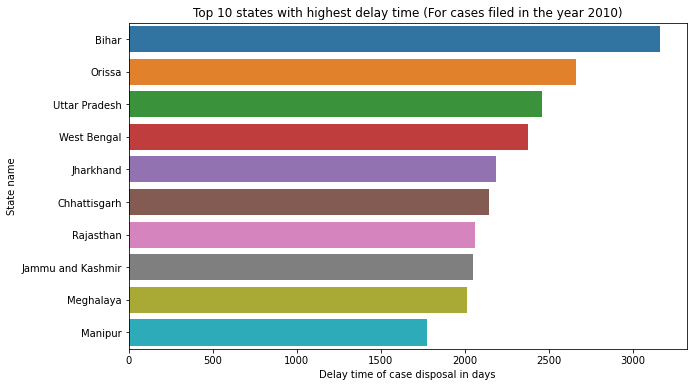

<Figure size 432x288 with 0 Axes>

In [132]:
plt.figure(figsize=(10, 6))
sns.barplot(x='justice_delay_time', y='state_name', data=delay_by_state_top_10)
plt.xlabel('Delay time of case disposal in days')
plt.ylabel('State name')
plt.title('Top 10 states with highest delay time (For cases filed in the year 2010)')
plt.show()
plt.savefig('drive/MyDrive/delay_in_case_disposal.png')